# How has the Netflix TV show *The Queen's Gambit* impacted online chess?

**Author:** David Zhang **Email:** dyzhang32@gmail.com

---

The queen's gambit chess opening is played at the highest levels of chess, characterised by moves: **1.d4 d5 3.c4**. [*The Queen's Gambit*](https://en.wikipedia.org/wiki/The_Queen%27s_Gambit_(miniseries)) TV show depicts Beth Harmon, a chess prodigy who struggles with drug addiction, conquer a male-dominated chess world. 

It's no secret that the popularity of *The Queen's Gambit* has caused a [recent surge in chess interest](https://www.nytimes.com/2020/11/23/arts/television/chess-set-board-sales.html). In fact, I myself am one of the many victims, having been re-inspired to pick up online chess. Inevitably, this has snowballed into a bit of an addiction, having played [375 rapid games in the last month](https://www.chess.com/games/archive?gameOwner=my_game&gameType=live&gameTypeslive%5B%5D=rapid&rated=rated&endDate%5Bdate%5D=02/01/2021&startDate%5Bdate%5D=01/01/2021&timeSort=desc), with most of my games as white beginning with the queen's gambit when possible. 

This has lead me to wonder how many other's have been bitten by *The Queen's Gambit* bug and how this would be reflected in online chess. In particular, I expect this would be identifiable through the 3 following metrics: 
   
   1. An increase in the **number of new players** joining online chess websites. 
   2. An increase in the **popularity of the Queen's Gambit and Sicilian openings**. 
   3. An increase in the **re-uptake of chess by inactive users**. 
    
Here, I try to test these hypotheses using the [chess.com](https://www.chess.com/) data. 

### Importing modules and setting plot styles

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

sns.set_style("ticks")
sns.set_context("talk")

### 1. Number of new players

*The Queen's Gambit* was released in the UK Netflix on the **23rd October 2020**. In order to see the impact of this on the number of players joining online chess, I'll use the chess.com API to download the UK-associated players that have joined within a 4 month window before or after October 23rd.

To begin, let's grab the joining date of UK players. To save time here (there's >200,000 UK players and it takes ~0.5 to download each player's data), I've randomly selected 1000 players. It's worth noting that we're limited by how accurately this reflects a user's country of residence during the period following *The Queen's Gambit* release.

In [2]:
# parse timestamps as date times
dp = lambda x: datetime.fromtimestamp(int(x))

join_dates = pd.read_csv("data/GB_players_joined_25_02_2021.csv", parse_dates = ["joined"], date_parser = dp)

join_dates.head()

,joined
0,2021-01-04 09:50:36
1,2020-12-02 23:53:58
2,2010-01-04 22:56:18
3,2021-02-22 19:49:20
4,2021-01-02 23:08:35


With the joining dates downloaded and formatted, we can filter for those dates residing in our window of interest. 

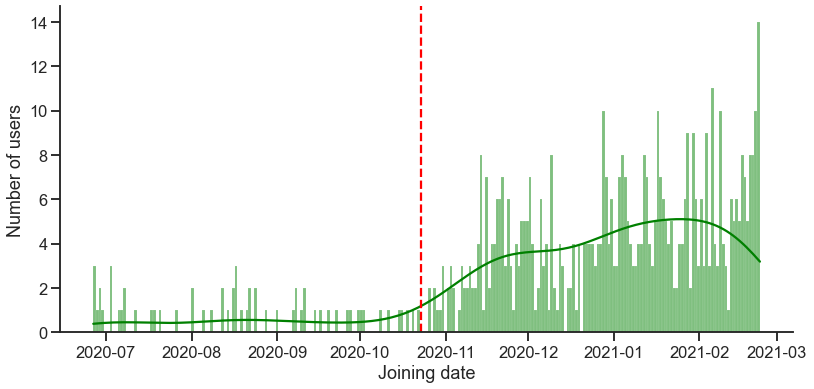

In [8]:
##### Data wrangling #####

def filter_dates_qg(join_dates, qg_date, months):
    
    earliest = qg_date - relativedelta(months = months)
    latest = qg_date + relativedelta(months = months)
    join_dates_qg = join_dates[(join_dates["joined"] >= earliest) & (join_dates["joined"] <= latest)].copy()
    
    return join_dates_qg

qg_date = datetime.strptime("2020-10-23", "%Y-%m-%d")

join_dates_qg = filter_dates_qg(join_dates, qg_date, 4)

# get number of days between our dates for use as bins
delta_days = (qg_date + relativedelta(months = 4)) - ((qg_date - relativedelta(months = 4)))
delta_days = delta_days.days

##### Plotting ######

joining_fig = sns.displot(data = join_dates_qg, x = "joined", 
                          bins = delta_days, kde = True, color = "g")
joining_fig = joining_fig.set(xlabel = "Joining date", ylabel = "Number of users")
joining_fig.fig.set_figwidth(15)
joining_fig.fig.set_figheight(6)
plt.axvline(qg_date, color = 'r', linestyle = "--")

After *The Queen's Gambit* UK release (marked with a <span style="color:red">red dashed line</span>) there's a dramatic and progressive increase in the number of user's joining chess.com (with the UK flag). More data would be needed to be sure, but it looks like this this explosion in people signing up to play online chess is still growing to this day! 

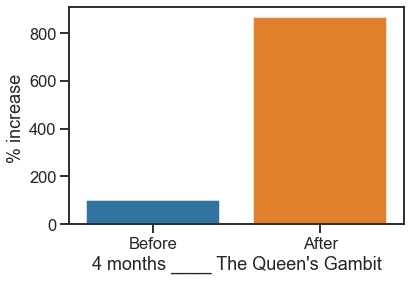

In [9]:
##### Data wrangling #####

# obtain a percentage of 
join_dates_qg.loc[: , ("qg")] = ["Before" if date <= qg_date else "After" for date in join_dates_qg['joined']]
joining_ba_qg = join_dates_qg.groupby("qg").count().reset_index()
joining_ba_qg["percent"] = (joining_ba_qg['joined']/joining_ba_qg['joined'].min()) * 100

##### Plotting #####

joining_ba_fig = sns.barplot(x = "qg", y = "percent", 
                             order = ["Before", "After"],
                             data = joining_ba_qg)
joining_ba_fig = joining_ba_fig.set(xlabel = "4 months ____ The Queen's Gambit", 
                                    ylabel = "% increase ")

As a consequence, this increase has meant there's **8x** the total number of people joining in the 4 month window after *The Queen's Gambit*, compared to before!

The release date of shows on Netflix varies by country. This allows us to further investigate whether this increase in user's joining correlates with *The Queen's Gambit* release. Based off of the [unofficial Netflix online global search](http://unogs.com/title/80234304) I picked 3 countries with different release dates and 1 where Netflix is not available: 

   1. **UK**: 23rd October 2020
   2. **Italy**: 28th November 2020
   3. **Columbia**: 12th January 2021
   4. **China**: Netflix unavailable

In [29]:
##### Data wrangling #####

join_dates_paths = [path for path in os.listdir("data/") if "players_joined" in path]

join_dates_all = []

# bind together join dates from all countries
for i in range(len(join_dates_paths)):

    join_dates = pd.read_csv("data/" + join_dates_paths[i], parse_dates = ["joined"], date_parser = dp)
    country = re.sub(r"_players.*", "", join_dates_paths[i])
    join_dates['country'] = country
    join_dates_all.append(join_dates)
    
join_dates_all = pd.concat(join_dates_all)

join_dates_all_qg = filter_dates_qg(join_dates_all, qg_date, 4)

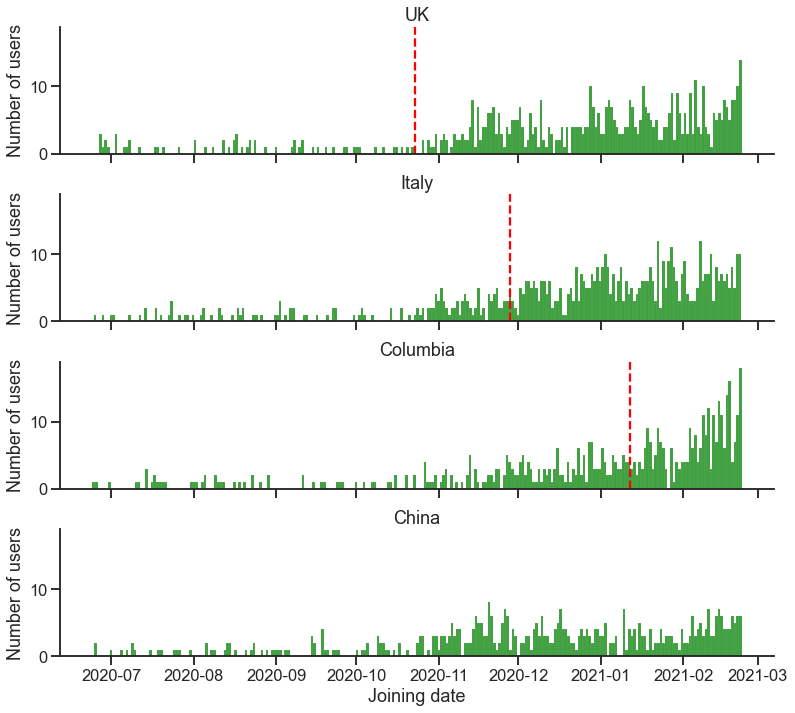

In [32]:
##### Plotting #####

joining_all_fig = sns.FacetGrid(data = join_dates_all_qg, row = "country",
                                row_order= ["GB", "IT", "CO", "CN"])
joining_all_fig.map(sns.histplot, "joined", bins = delta_days, color = "g")
joining_all_fig.set(xlabel = "Joining date", ylabel = "Number of users")
joining_all_fig.fig.set_figwidth(18)
joining_all_fig.fig.set_figheight(10)

axes = joining_all_fig.axes.flatten()
axes[0].set_title("UK")
axes[1].set_title("Italy")
axes[2].set_title("Columbia")
axes[3].set_title("China")
axes[0].axvline(qg_date, color = 'r', linestyle = "--")
axes[1].axvline(datetime.strptime("2020-11-28", "%Y-%m-%d"), color = 'r', linestyle = "--")
axes[2].axvline(datetime.strptime("2021-01-12", "%Y-%m-%d"), color = 'r', linestyle = "--")

Again, 1000 random players have been grabbed for each country and *The Queen's Gambit* release date is marked with a <span style="color:red">red dashed line</span>. 

It is unclear whether the exact release date *The Queen's Gambit* of different countries marks the point when the number of user's joining starts to increase in that corresponding country. That being said, we can see a potential shift towards later joining dates for Columbia, the country with the latest release date. Interestingly, from the 23rd October 2020 there is an increase in the number of players joining chess.com for all 4 countries. It plausible that this may be due to the availibity of VPNs and other *unofficial* methods, which can allow people to access Netflix shows outside of their country of residence. It does seem the case that China has seen a less dramatic increase in online chess uptake, potentially due to the greater online restrictions present there. 

### 2. Popularity of the Queen's Gambit and Sicilian openings 